# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The key objective  from the business perspective is  identifying which  attributes impact the price of used cars. This information will be valuable to used car deals in fine tuning their inventory. This can be achieved building a  regression model for price of used cars based on different attributes including year, make, model, condition, odometer reading, number of cylinders, type of fuel, drive, transmission, size, type of vehicle and color. The magnitudes of regression coefficients as well as other model inspection techniques can reveal useful information in  ranking features in order of their impact on the target variable ('price') and accordingly determine the top features that influence price.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

The first step of data understanding is exploring what data has been collected.  In this case there are 426880 entries with 18 attributes, 4 numeric attributes and the rest categorical. There are  several columns with missing data. A quick check of the descriptive statistics of the numeric attributes indicate that there are also outliers in numeric attributes, price and odometer.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from scipy import stats
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance

In [34]:
vehicles = pd.read_csv('data/vehicles.csv')
vehicles.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
281909,7315853427,utica-rome-oneida,21990,2020.0,volkswagen,golf 1.4t tsi,good,NaN,gas,2515.0,clean,other,3VWW57AU2LM008847,fwd,NaN,sedan,black,ny
232349,7314942425,charlotte,0,2017.0,bmw,340i,NaN,NaN,gas,55356.0,clean,automatic,WBA8B7G51HNU37475,NaN,compact,sedan,black,nc
102712,7312278746,ocala,8750,2016.0,toyota,corolla,NaN,NaN,gas,117795.0,clean,automatic,2T1BURHE3GC585058,fwd,NaN,sedan,black,fl
21654,7314444074,bakersfield,34900,2012.0,ford,econoline,good,8 cylinders,gas,164279.0,clean,automatic,NaN,rwd,full-size,truck,white,ca
105683,7314315636,orlando,23996,2017.0,lexus,es 350,NaN,6 cylinders,gas,64043.0,clean,automatic,NaN,fwd,mid-size,sedan,silver,fl


In [35]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

Based on vehicles.info() there are a large number of missing data from the columns condition, cylinders, VIN, drive, size, type, paint color. These features will therefore not be used for the model as there's no reliable way to replace so many instances of missing data corresponding to these features without introducing some sort of error or bias. There are other features like year, manufacturer, model, fuel, transmission, state, odometer reading, each of which is known to impact used car price. There's a smaller amount of missing data for these features and there will still be sufficient data left after elimination of missing data corresponding to these features.

In [36]:
vehicles.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


The price and odometer columns seem to have some outliers based on the descriptive statistics: for example the max value of price seems unrealistically high whereas minimum value is 0. 

[Text(0, 0, 'gmc'),
 Text(1, 0, 'chevrolet'),
 Text(2, 0, 'toyota'),
 Text(3, 0, 'ford'),
 Text(4, 0, 'jeep'),
 Text(5, 0, 'nissan'),
 Text(6, 0, 'ram'),
 Text(7, 0, 'mazda'),
 Text(8, 0, 'cadillac'),
 Text(9, 0, 'honda'),
 Text(10, 0, 'dodge'),
 Text(11, 0, 'lexus'),
 Text(12, 0, 'jaguar'),
 Text(13, 0, 'buick'),
 Text(14, 0, 'chrysler'),
 Text(15, 0, 'volvo'),
 Text(16, 0, 'audi'),
 Text(17, 0, 'infiniti'),
 Text(18, 0, 'lincoln'),
 Text(19, 0, 'alfa-romeo'),
 Text(20, 0, 'subaru'),
 Text(21, 0, 'acura'),
 Text(22, 0, 'hyundai'),
 Text(23, 0, 'mercedes-benz'),
 Text(24, 0, 'bmw'),
 Text(25, 0, 'mitsubishi'),
 Text(26, 0, 'volkswagen'),
 Text(27, 0, 'porsche'),
 Text(28, 0, 'kia'),
 Text(29, 0, 'rover'),
 Text(30, 0, 'ferrari'),
 Text(31, 0, 'mini'),
 Text(32, 0, 'pontiac'),
 Text(33, 0, 'fiat'),
 Text(34, 0, 'tesla'),
 Text(35, 0, 'saturn'),
 Text(36, 0, 'mercury'),
 Text(37, 0, 'harley-davidson'),
 Text(38, 0, 'datsun'),
 Text(39, 0, 'aston-martin'),
 Text(40, 0, 'land rover'),
 Tex

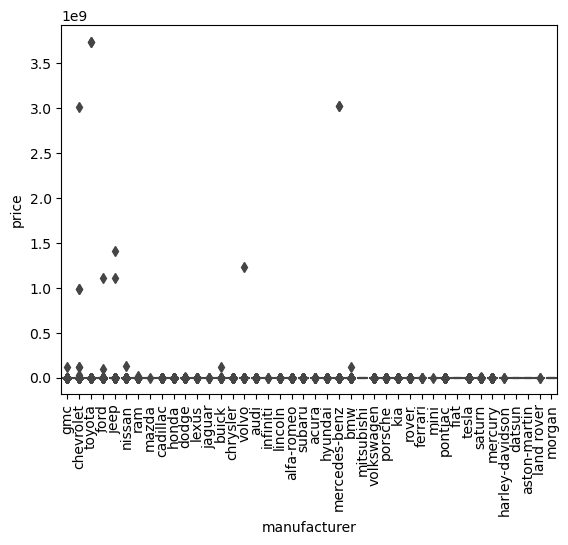

In [37]:
ax = sns.boxplot(data=vehicles, x='manufacturer', y='price')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

It's also evident from the above plot that outlier data is present, esp for the price variable which needs to be addressed.

In [38]:
#exploring contents of the some of the categorical features

vehicles['fuel'].value_counts()

gas         356209
other        30728
diesel       30062
hybrid        5170
electric      1698
Name: fuel, dtype: int64

In [39]:
vehicles['transmission'].value_counts()

automatic    336524
other         62682
manual        25118
Name: transmission, dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

First step in data preparation process is removal of outlier data for the numerical columns 'price' and 'odometer'. This is accomplished based on removing data more or less than 1.5 times the interquartile ranges from the third and first quartile respectively. Also since several datapoints for the price variable are on the lower side (0 or close to 0), the lower limit may not be adequate for removal of outliers on the lower side of the range, so a value threshold of 500 is set below which data for price is removed.

In [40]:
#remove outliers from numeric columns based on values below or above 1.5 times inter quartile range from the first and third quartiles respectively
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > np.max([fence_low, 500])) & (df_in[col_name] < fence_high)]
    return df_out

data = remove_outlier(vehicles, 'price')
data=remove_outlier(data,'odometer')


[Text(0.5, 1.0, 'Used Car Prices for Different Manufacturers')]

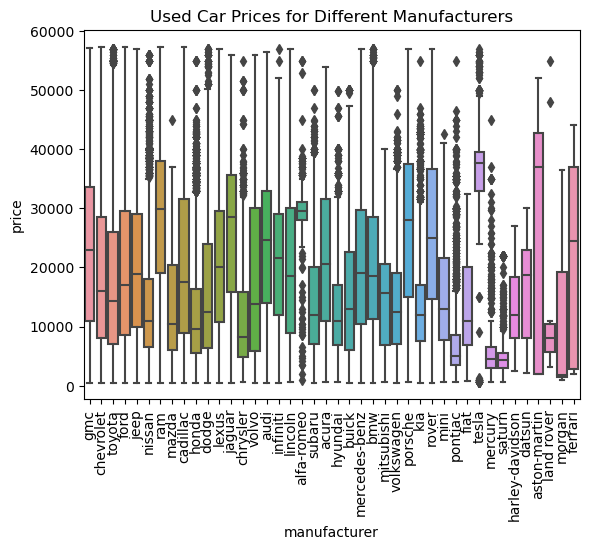

In [41]:
ax = sns.boxplot(data=data, x='manufacturer', y='price')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(title='Used Car Prices for Different Manufacturers')

<AxesSubplot:xlabel='price', ylabel='Count'>

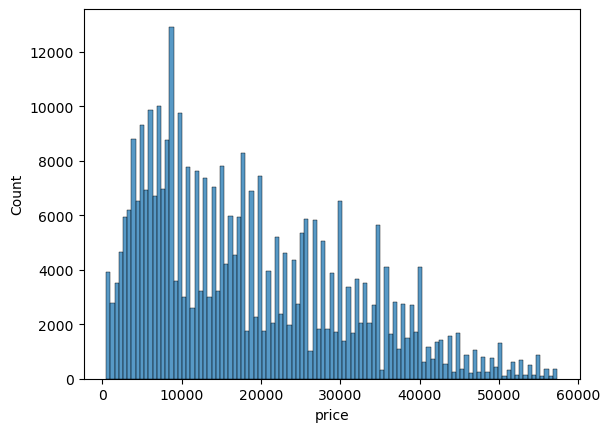

In [42]:
sns.histplot(data=data, x='price')

Based on these plots, it seems like the outlier removal process was successful.

In [43]:
#check on data size and info after removing outliers
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363695 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            363695 non-null  int64  
 1   region        363695 non-null  object 
 2   price         363695 non-null  int64  
 3   year          362869 non-null  float64
 4   manufacturer  350828 non-null  object 
 5   model         359985 non-null  object 
 6   condition     228566 non-null  object 
 7   cylinders     216984 non-null  object 
 8   fuel          361532 non-null  object 
 9   odometer      363695 non-null  float64
 10  title_status  357518 non-null  object 
 11  transmission  362313 non-null  object 
 12  VIN           224969 non-null  object 
 13  drive         253990 non-null  object 
 14  size          103558 non-null  object 
 15  type          287621 non-null  object 
 16  paint_color   260300 non-null  object 
 17  state         363695 non-null  object 
dtypes: 

Based on data.info() there are a large number of missing data from the columns condition, cylinders, VIN, drive, size, type, paint color. These features will therefore not be used for the model. The 'region' and 'state' both convey information on location, it will be adequate to include just one of them, 'state', for modeling purposes as variation in price for regions within a state are probably going to be not as much as variation from one state to another.

Before getting the data ready for modeling we explore the effect of a few variables on price which will help us make important decisions on what to incorporate in the model. This is easier to do at this stage after the outlier prices have been removed as one of the first steps of data preparation.

[Text(0.5, 1.0, 'Effects of Fuel Type on Used Car Price')]

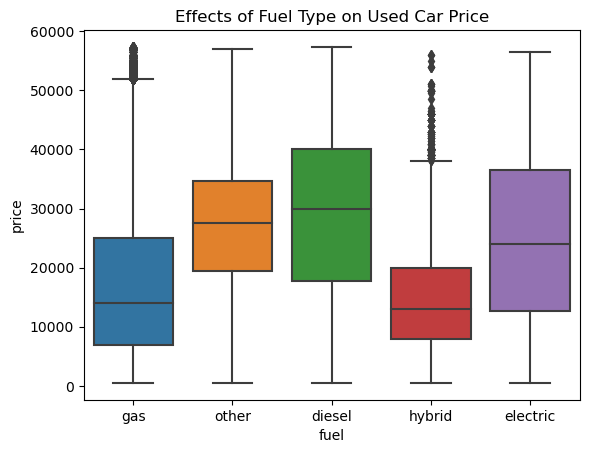

In [12]:
sns.boxplot(data=data, x='fuel', y='price').set(title='Effects of Fuel Type on Used Car Price')

Majority of the vehicles have fuel type as 'gas' but the median prices of electric vehicles or vehicles with fuel type as diesel or other are higher.

[Text(0.5, 1.0, 'Effects of Type of Transmission on Used Car Price')]

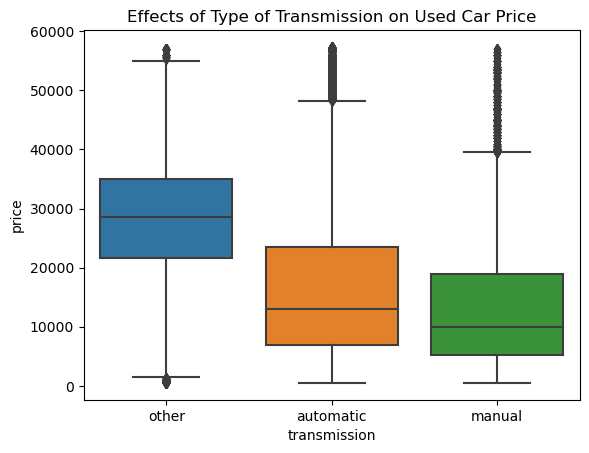

In [13]:
sns.boxplot(data=data, x='transmission', y='price').set(title='Effects of Type of Transmission on Used Car Price')

Transmission types also affect car prices: median prices of vehicles with auto transmission are higher than those with manual. Interestingly, median price is highest for vehicles where tranmission type is described as 'other'

[Text(0.5, 1.0, 'Effects of Title Status on Used Car Price')]

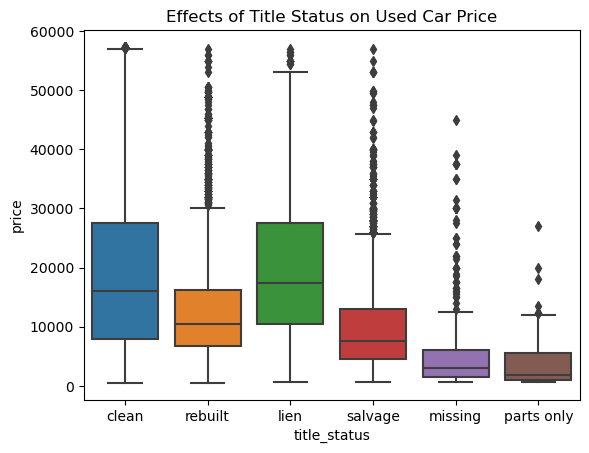

In [14]:
sns.boxplot(data=data, x='title_status', y='price').set(title='Effects of Title Status on Used Car Price')

Title status plays a role with clean or lien titles fetching more price than salvage, missing or parts only

[Text(0.5, 1.0, 'Condition vs Price')]

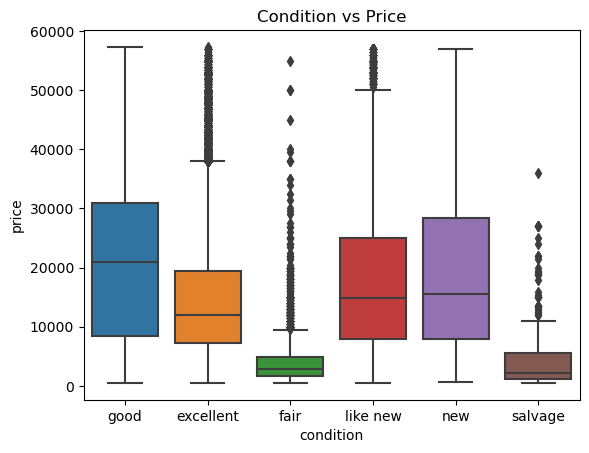

In [15]:
sns.boxplot(data=data, x='condition', y='price').set(title='Condition vs Price')

Condition is a subjective description and it is not strictly ordinal in nature from the perspective of pricing : for example cars in good condition fetch higher prices on an average than those in excellent condition and are similarly priced as 'new' or 'like new'. Cars with condition as 'fair' or 'salvage' are priced lower as would have been expected.

[Text(0.5, 1.0, 'Condition vs Odometer')]

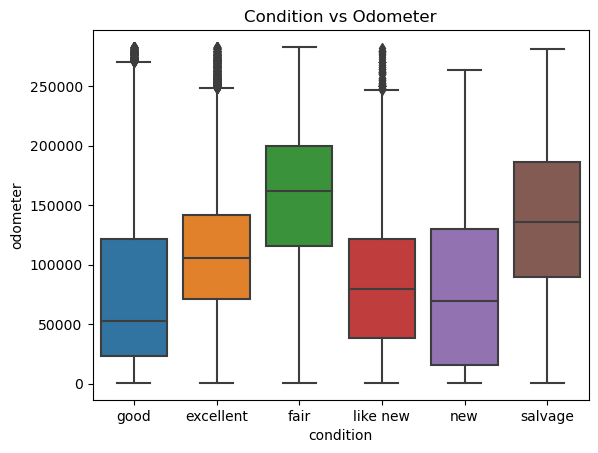

In [16]:
sns.boxplot(data=data, x='condition', y='odometer').set(title='Condition vs Odometer')

Earlier we saw that cars with condition described as 'fair' or 'salvage' are in general priced lower. From the above graph, we see that cars in good, excellent, like new and new conditions have a lower odometer reading on average than cars whose conditions are described as 'fair' or 'salvage'. This is important as condition is missing on a lot more entries than odometer, so the model will most likely not lose valuable information if condition is not incorporated in the model (due to the amount of data missing on condition) but odometer is included.

Earlier we saw that prices vary based on different manufacturers. Here we want to get a sense of how price varies as a function of  odometer readings and year.  For ease of visualization of these relationships, we perform these analyses for a particular manufacturer, say Honda

In [44]:
data_Honda=data.loc[data['manufacturer'] == 'honda']
data_Honda.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
59,7313406529,auburn,14000,2012.0,honda,odyssey,excellent,6 cylinders,gas,95000.0,clean,automatic,NaN,fwd,full-size,mini-van,silver,al
74,7311960895,auburn,26590,2020.0,honda,civic si coupe 2d,good,NaN,gas,9954.0,clean,other,2HGFC3A51LH751302,fwd,NaN,coupe,silver,al
75,7311818339,auburn,18590,2018.0,honda,civic lx sedan 4d,good,NaN,gas,28942.0,clean,other,19XFC2F59JE206832,fwd,NaN,sedan,white,al
77,7311818157,auburn,21590,2018.0,honda,civic ex sedan 4d,good,NaN,gas,7885.0,clean,other,2HGFC2F74JH589649,fwd,NaN,sedan,NaN,al
178,7316869910,birmingham,12950,2011.0,honda,crv ex,excellent,4 cylinders,gas,87994.0,clean,automatic,NaN,fwd,NaN,SUV,silver,al


[Text(0.5, 1.0, 'Year vs Price for Cars Manufactured by Honda')]

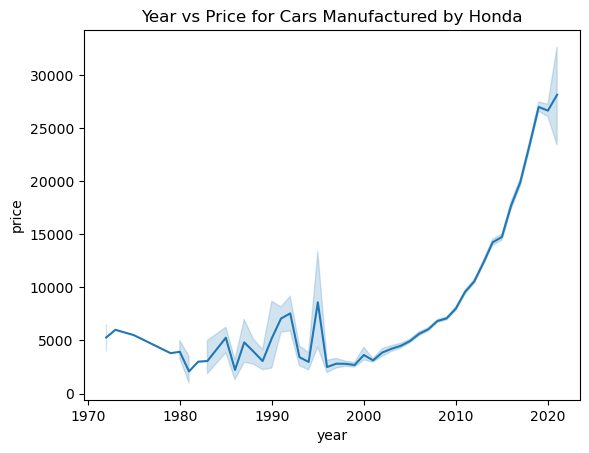

In [18]:
sns.lineplot(data=data_Honda, x='year', y='price').set(title = 'Year vs Price for Cars Manufactured by Honda')

It's easy to see from the above plot that more recent the year, higher the price in general. It's also interesting that the relationship is not linear but seems like parabolic, hinting at the possiblity of modeling using higher order polynomial regression.

[Text(0.5, 1.0, 'Odometer vs Price for Cars Manufactured by Honda')]

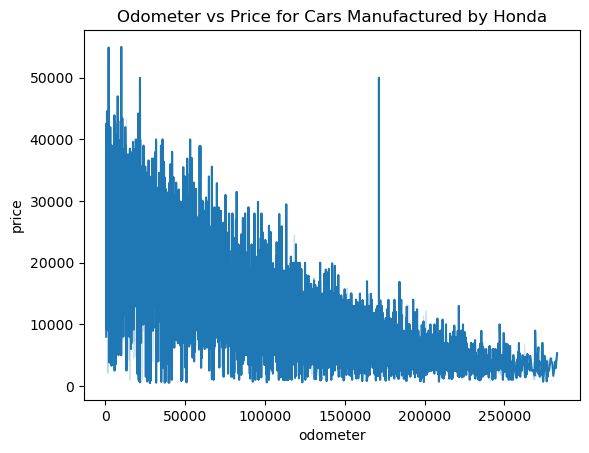

In [25]:
sns.lineplot(data=data_Honda, x='odometer', y='price').set(title = 'Odometer vs Price for Cars Manufactured by Honda')

This data seems more noisy but it is apparent with with higher odometer, the price in general goes down suggesting a negative association between odometer and price

###### Based on the above analysis and availability of data, we choose the following features for our model: price, year, manufacturer, model, fuel, odometer, title_status, transmission, state

In [45]:
#Extracting features that will be used for model development into a separate dataframe df
df = data[['price', 'year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission', 'state']]

#dropping NaN values from the dataframe df
df=df.dropna()
df.shape

(338533, 9)

In [46]:
df.describe()

,price,year,odometer
count,338533.000000,338533.000000,338533.000000
mean,18397.821551,2011.440244,93832.627883
std,12509.209397,8.375689,60304.866812
min,501.000000,1900.000000,501.000000
25%,7900.000000,2008.000000,41000.000000
50%,15900.000000,2013.000000,90000.000000
75%,26999.000000,2017.000000,136376.000000
max,57341.000000,2022.000000,283231.000000


The ranges of numeric data appear reasonable even though there's still a difference in scales especially when comparing amongst the different features. For example, year is in the scale of thousands, price can be of the order of tens of thousands while odometer can go up to the order of hundreds of thousands. It is clear that ***scaling*** will be important when we develop models and we plan to incorporate the StandardScaler in our pipeline for the different models to take care of differences in scales.

There are several categorical variables like manufacturer and model which are believed to have major impact on price. These are not ordinal.  Due to the high cardinality of these categorical features, one-hot encoding is not used. Instead, leave one out encoding is used which will avoid introducing additional columns/features for each of these categorical variables while at the same time minimizing the likelihood of overfitting. Leave one out encoding is just target encoding where the average or expected value is calculated ignoring the value in the current row. It is believed to have lesser issues with bias and overfitting than traditional target encoding, hence it is deemed to be a good choice for this particular problem. Category encoders is installed so that LeaveOneOutEncoder can be used.

In [12]:
pip install category_encoders


Note: you may need to restart the kernel to use updated packages.


In [47]:
import category_encoders as ce

Next step is dividing data into train test splits for ***hold out cross-validaton*** using the default test size of 0.25 and setting the random_state to a fixed integer so that the same train/test sets are used for multiple calls comparing across different models. After train test split, the categorical variables are encoded by leave one out encoding. The approach to leave one encoding is different for the test set compared to the train set. Since leave one out encoding utilizes the value of the target variable ('price' in this case), the encoding for the train set is done first and then the test set is encoded without utilizing the test values of the target variable. **This is important so as not to overfit and/or bias the results (due to'data leakage') of the model on the test dataset.** 

In [48]:
y = df['price']  #target variable
X = df.drop(columns=['price']) #input features excluding target variable

# split into train/test data: X_tr is the input training set without encoding, X_te is the test set without encoding
X_tr, X_te, y_train, y_test = train_test_split(X, y, random_state = 42)


#Encode categorical features using Leave One out Encoding: The Encoding for test data is done without using test values of target variable
encoder = ce.LeaveOneOutEncoder(return_df=True)

#X_train is the training dataset after leave one out encoder has been applied to categorical features
X_train = encoder.fit_transform(X_tr, y_train)

# the test set is encoded without utilizing values of y_test
X_test = encoder.transform(X_te)








In [49]:
X_train.corr()

,year,manufacturer,model,fuel,odometer,title_status,transmission,state
year,1.000000,0.056327,0.288338,0.082843,-0.394857,0.046416,0.309147,0.058046
manufacturer,0.056327,1.000000,0.433893,0.197081,-0.061796,0.043781,0.079460,0.055237
model,0.288338,0.433893,1.000000,0.332379,-0.370573,0.076722,0.443511,0.097809
fuel,0.082843,0.197081,0.332379,1.000000,-0.039621,0.034089,0.202102,0.032495
odometer,-0.394857,-0.061796,-0.370573,-0.039621,1.000000,-0.003390,-0.447104,-0.070538
title_status,0.046416,0.043781,0.076722,0.034089,-0.003390,1.000000,0.068520,-0.003664
transmission,0.309147,0.079460,0.443511,0.202102,-0.447104,0.068520,1.000000,-0.005253
state,0.058046,0.055237,0.097809,0.032495,-0.070538,-0.003664,-0.005253,1.000000


A quick check of the correlation among the different features does not reveal any instances of variables with strong mutual correlation- this is important for making sure we don't have a model with high level of multi-collinearity. This ends the data preparation step and we are ready for the next step of modeling

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

The modeling stage involves building a variety of models starting with linear regression  and then going to the ridge and lasso models. Hold-out cross validation is performed to assess the performance of each model on the test data. The target variable is price and input features are year, manufacturer, model, fuel, odometer, title_status, transmission and state.

We start building simple models first without introducing polynomial complexity. Though simpler models may be less accurate 
they are easier to interpret in terms of the regression coefficients and the relative impact of different features on target variable

#### Linear Regression Model

In [50]:
# building a simple linear regression model

pipeLR = Pipeline([('scale', StandardScaler()),
                     ('linreg', LinearRegression())])
    
pipeLR.fit(X_train, y_train)
train_preds_LR = pipeLR.predict(X_train)
y_preds_LR = pipeLR.predict(X_test)
train_mses_LR = mean_squared_error(y_train, train_preds_LR)
test_mses_LR = mean_squared_error(y_test, y_preds_LR)
train_r2score_LR = r2_score(y_train, train_preds_LR)
test_r2score_LR = r2_score(y_test, y_preds_LR)

#print train and test scores for the model 
print ('\nLinear Regression Model: Model Scores and Coefficients\n\n')
print('Train MSE:',np.around(train_mses_LR,2))
print('Train r2 score:', np.around(train_r2score_LR,2))
print('Test MSE:',np.around(test_mses_LR,2))
print('Test RMSE:', np.around(np.sqrt(test_mses_LR),2))
print('Test r2 score:', np.around(test_r2score_LR,2))

#Inspecting coefficients of the model
LR_coefs = pipeLR.named_steps['linreg'].coef_

list_LR_coeff = list((zip(pipeLR.named_steps['scale'].get_feature_names_out(), pipeLR.named_steps['linreg'].coef_)))

df_LR_coeff = pd.DataFrame(list_LR_coeff, columns = [' Features', 'LR Coefficients'])

#sort features by magnitude of linear regression coefficents
df_LR_coeff.sort_values(by='LR Coefficients', ascending=False, key=abs)


Linear Regression Model: Model Scores and Coefficients


Train MSE: 41136000.72
Train r2 score: 0.74
Test MSE: 41987760.46
Test RMSE: 6479.8
Test r2 score: 0.73


,Features,LR Coefficients
2,model,7286.036170
4,odometer,-4412.660174
0,year,1893.485230
6,transmission,-1502.825448
3,fuel,1130.092094
7,state,761.547553
5,title_status,692.929776
1,manufacturer,651.132298


#### Ridge Regression with GridSearchCV for the 'best' alpha

In [51]:
# building a Ridge Regression model using GridSearchCV for tuning hyperparameter 'alpha'

pipeRidge = Pipeline( [('scale', StandardScaler()),('ridge', Ridge())])
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 500.0, 1000.0]}
gridRidge = GridSearchCV(pipeRidge, param_grid=param_dict)
gridRidge.fit(X_train, y_train)
train_predsRidge = gridRidge.predict(X_train)
test_predsRidge = gridRidge.predict(X_test)
train_mseRidge = mean_squared_error(y_train, train_predsRidge)
train_r2scoreRidge = r2_score(y_train, train_predsRidge)
test_mseRidge = mean_squared_error(y_test, test_predsRidge)
test_r2scoreRidge = r2_score(y_test, test_predsRidge)
best_alphaRidge = gridRidge.best_params_

# print best alpha and model train and test scores
print ('\nRidge Regression Model: Best Alpha and Model Scores\n\n')
print(f'Best Alpha: {list(best_alphaRidge.values())[0]}')
print('Train MSE:',np.around(train_mseRidge,2))
print('Train r2 score:', np.around(train_r2scoreRidge,2))
print('Test MSE:',np.around(test_mseRidge,2))
print('Test RMSE:', np.around(np.sqrt(test_mseRidge),2))
print('Test r2 score:', np.around(test_r2scoreRidge,2))



Ridge Regression Model: Best Alpha and Model Scores


Best Alpha: 10.0
Train MSE: 41136000.89
Train r2 score: 0.74
Test MSE: 41987805.35
Test RMSE: 6479.8
Test r2 score: 0.73


Regularization does not help improve performance of the model: the best alpha is 10.0 and the performance of the Ridge model is no better than simple Linear Regression. Let's inspect the ridge coefficients next for the ridge model with best alpha

In [53]:
#Inspect the coefficients of the ridge model with best alpha=10.0
pipe_bestalpha_ridge = Pipeline([('scale', StandardScaler()), ('ridge', Ridge(alpha=10.0))])
pipe_bestalpha_ridge.fit(X_train, y_train)


list_Ridge_coeff = list((zip(pipe_bestalpha_ridge.named_steps['scale'].get_feature_names_out(), pipe_bestalpha_ridge.named_steps['ridge'].coef_)))

df_Ridge_coeff = pd.DataFrame(list_Ridge_coeff, columns = [' Features', 'Ridge Coefficients'])

print('\nRidge Regression Coefficients\n\n')

#sort features by magnitude of ridge regression coefficents
df_Ridge_coeff.sort_values(by='Ridge Coefficients', ascending=False, key=abs)


Ridge Regression Coefficients




,Features,Ridge Coefficients
2,model,7285.603075
4,odometer,-4412.493471
0,year,1893.496386
6,transmission,-1502.515883
3,fuel,1130.106371
7,state,761.564126
5,title_status,692.907793
1,manufacturer,651.276872


Both linear and ridge regression models indicate that the most impactful factors that are positively associated with price are model and year, and the most impactful factors affecting price negatively are odometer and transmission

#### Lasso Model with GridSearchCV for optimal lasso alpha

In [54]:
#Next implementing the lasso model : picking the best alpha parameter for the lasso model

lasso_alphas = [0.001,0.01,0.1,1.0, 10.0]
lasso = Lasso(random_state=123)
grid = dict()
grid['alpha'] = lasso_alphas

gscv_lasso = GridSearchCV( \
    lasso, grid, scoring='neg_mean_squared_error', \
    cv=3, n_jobs=-1)

gscv_lasso.fit(X_train, y_train)
train_predsLasso = gscv_lasso.predict(X_train)
test_predsLasso = gscv_lasso.predict(X_test)
train_mseLasso = mean_squared_error(y_train, train_predsLasso)
train_r2scoreLasso = r2_score(y_train, train_predsLasso)
test_mseLasso = mean_squared_error(y_test, test_predsLasso)
test_r2scoreLasso = r2_score(y_test, test_predsLasso)
best_alphaLasso = gscv_lasso.best_params_

# print best alpha and model train and test scores for Lasso model
print ('\nLasso Model: Best Alpha and Model Scores\n\n')
print(f'Best Alpha: {list(best_alphaLasso.values())[0]}')
print('Train MSE:',np.around(train_mseLasso,2))
print('Train r2 score:', np.around(train_r2scoreLasso,2))
print('Test MSE:',np.around(test_mseLasso,2))
print('Test RMSE:', np.around(np.sqrt(test_mseLasso),2))
print('Test r2 score:', np.around(test_r2scoreLasso,2))



Lasso Model: Best Alpha and Model Scores


Best Alpha: 0.001
Train MSE: 41136000.72
Train r2 score: 0.74
Test MSE: 41987760.48
Test RMSE: 6479.8
Test r2 score: 0.73


Lasso has similar performance as Linear/Ridge regressors. Next we inspect the coefficients of the Lasso model with best alpha

In [55]:
#Inspect the coefficients of the Lasso model with best alpha=0.001
pipe_bestalpha_lasso = Pipeline([('scale', StandardScaler()), ('lasso', Lasso(alpha=0.001, random_state=123))])
pipe_bestalpha_lasso.fit(X_train, y_train)

list_Lasso_coeff = list((zip(pipe_bestalpha_lasso.named_steps['scale'].get_feature_names_out(), pipe_bestalpha_lasso.named_steps['lasso'].coef_)))

df_Lasso_coeff = pd.DataFrame(list_Lasso_coeff, columns = [' Features', 'Lasso Coefficients'])

print('\nLasso Coefficients\n\n')

#sort features by magnitude of lasso coefficents
df_Lasso_coeff.sort_values(by='Lasso Coefficients', ascending=False, key=abs)


Lasso Coefficients




,Features,Lasso Coefficients
2,model,7286.035532
4,odometer,-4412.658758
0,year,1893.484398
6,transmission,-1502.822964
3,fuel,1130.091089
7,state,761.546834
5,title_status,692.928753
1,manufacturer,651.131785


All three models have similar results. Next we explore Sequential Feature Selection using LinearRegression

#### Sequential Feature Selection using Linear Regression Estimator

In [56]:
#SequentialFeature selector with number of features = 5 and LinearRegression estimator
pipeSFSelector = Pipeline([('scale', StandardScaler()),('linreg', LinearRegression())])
SFSelector = SequentialFeatureSelector(pipeSFSelector, n_features_to_select=5)

#best four features from Sequential Feature Selection
best_features_SFSelector = SFSelector.fit_transform(X_train, y_train)
best_featuresSFSelector_df = pd.DataFrame(best_features_SFSelector, columns = SFSelector.get_feature_names_out())
best_featuresSFSelector_df.head()

,year,model,fuel,odometer,transmission
0,2014.0,10507.477124,16982.738674,31500.0,16534.742852
1,2012.0,15249.217659,16982.825897,142504.0,16534.839105
2,2012.0,8579.409091,16982.831631,107000.0,16534.845433
3,2007.0,45900.000000,29857.136058,86000.0,16534.657232
4,2010.0,15607.641399,16982.832779,207246.0,16534.846699


In [57]:
#pipeline with column selector from Sequential Feature Selection
pipelineSFSLR = Pipeline([('column_selector', SFSelector),
                  ('scale', StandardScaler()),
                ('linreg', LinearRegression())])

pipelineSFSLR.fit(X_train, y_train)
train_preds_SFSLR = pipelineSFSLR.predict(X_train)
y_preds_SFSLR = pipelineSFSLR.predict(X_test)
train_mse_SFSLR = mean_squared_error(y_train, train_preds_SFSLR)
train_r2score_SFSLR = r2_score(y_train, train_preds_SFSLR)
test_mse_SFSLR = mean_squared_error(y_test, y_preds_SFSLR)
test_r2score_SFSLR = r2_score(y_test, y_preds_SFSLR)

# print  model train and test scores for SFS with LR
print ('\nSequential Feature Selection With Linear Regression Estimator: Model Scores and Coefficients\n\n')
print('Train MSE:',np.around(train_mse_SFSLR,2))
print('Train r2 score:', np.around(train_r2score_SFSLR,2))
print('Test MSE:',np.around(test_mse_SFSLR,2))
print('Test RMSE:', np.around(np.sqrt(test_mse_SFSLR),2))
print('Test r2 score:', np.around(test_r2score_SFSLR,2))


list_SFSLR_coeff = list((zip(pipelineSFSLR['column_selector'].get_feature_names_out(), pipelineSFSLR['linreg'].coef_)))

df_SFSLR_coeff = pd.DataFrame(list_SFSLR_coeff, columns = ['SFS Features', 'Model Coefficients'])

#sort features by magnitude of model coefficents
df_SFSLR_coeff.sort_values(by='Model Coefficients', ascending=False, key=abs)



Sequential Feature Selection With Linear Regression Estimator: Model Scores and Coefficients


Train MSE: 42529394.36
Train r2 score: 0.73
Test MSE: 43472325.81
Test RMSE: 6593.35
Test r2 score: 0.72


,SFS Features,Model Coefficients
1,model,7731.596048
3,odometer,-4378.475565
0,year,1920.023390
4,transmission,-1608.045085
2,fuel,1179.112400


Sequential Feature Selection showed how a simpler model can built with fewer (5) features, where the top features in order of magnitude of coefficients, and hence in the order of highest (positive or negative) impact on price are:

1) Model (positive)

2) Odomoter (negative)

3) Year (positive)

4) Transmission (negative)

5) Fuel (positive)

#### Higher Order Regression Models with Polynomial Features

Next we evaluate the effect of increasing complexity with PolynomialFeatures and iterating through different complexites from degree = 1 through degree = 4 and a LinearRegession estimator. We evaluate the best complexity based on the test mean squared error.


Linear Regression with Higher Order Polynomials



Best complexity: 2
Test MSEs:
 [41987760.46 34768913.41 37366410.8  39980812.06]

Test RMSEs:
 [6479.8  5896.52 6112.81 6323.04]

Test r2 scores:
 [0.73 0.78 0.76 0.75]


Text(0.5, 1.0, 'Selection of Optimal Model Complexity\nBased on Test MSE')

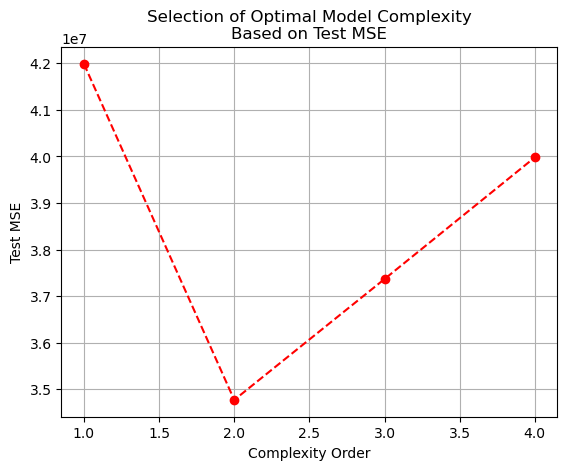

In [58]:
# building a pipeline model with polynomial features and linear regression to test different  models of increasing complexity
train_mses = []
train_r2score=[]
test_mses = []
test_r2score=[]
for i in range(1, 5):
    pipe = Pipeline([('pfeat', PolynomialFeatures(degree = i, include_bias=False)),
                     ('scale', StandardScaler()),
                     ('linreg', LinearRegression())])
    
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    y_preds = pipe.predict(X_test)
    train_mses.append(mean_squared_error(y_train, train_preds))
    test_mses.append(mean_squared_error(y_test, y_preds))
    train_r2score.append(r2_score(y_train, train_preds))
    test_r2score.append(r2_score(y_test, y_preds))

    
# find the best model complexity best on the testing error (and not training error)
best_model_complexity = test_mses.index(min(test_mses)) + 1

print('\nLinear Regression with Higher Order Polynomials\n')
print('\n\nBest complexity:' , best_model_complexity)
print('Test MSEs:\n', np.around(test_mses,2))
print('\nTest RMSEs:\n', np.around(np.sqrt(test_mses),2))
print('\nTest r2 scores:\n', np.around(test_r2score,2))

plt.plot(np.arange(1,5), test_mses, 'ro--')
plt.grid()
plt.xlabel('Complexity Order')
plt.ylabel('Test MSE')
plt.title('Selection of Optimal Model Complexity\nBased on Test MSE')

The best performing pipeline was the linear regression model with standard scaler and a polynomial complexity of degree=2. Based on the model scores, this particular model had an MSE of 34768913.4 and a r2 score of 0.78 which is an improvement over the scores achieved with simple linear regression model. Below are the train mses of the different models

In [59]:
print('Train MSEs:\n',train_mses)
print('Train r2 scores:\n', train_r2score)

Train MSEs:
 [41136000.720969595, 34174552.48932152, 29418500.49727003, 27443372.76305495]
Train r2 scores:
 [0.7367715573474787, 0.781317724804364, 0.8117516060057506, 0.8243904087188254]


Even though training MSEs and r2 scores improve with more complex polynomial models with order>2, this is due to overfitting and the test dataset actually reflects that in terms of worsening test errors with models of orders higher than 2. Therefore the optimal complexity is degree=2

#### Transformed Target Regressor: Does target transformation improve model performance?

In [60]:
#using logarithm to transform target
ttlinreg = TransformedTargetRegressor(regressor=LinearRegression(),func=np.log1p, inverse_func=np.expm1)


train_mses_TTReg = []
test_mses_TTReg = []
train_r2score_TTReg =[]
test_r2score_TTReg = []

for i in range(1, 5):
    pipeTTReg = Pipeline([('pfeat', PolynomialFeatures(degree = i, include_bias=False)), ('scale', StandardScaler()),
                    ('ttlinreg', ttlinreg)])
    pipeTTReg.fit(X_train, y_train)
    train_preds_TTReg = pipeTTReg.predict(X_train)
    y_preds_TTReg = pipeTTReg.predict(X_test)
    train_mses_TTReg.append(mean_squared_error(y_train, train_preds_TTReg))
    test_mses_TTReg.append(mean_squared_error(y_test, y_preds_TTReg))
    train_r2score_TTReg.append(r2_score(y_train, train_preds_TTReg))
    test_r2score_TTReg.append(r2_score(y_test, y_preds_TTReg))

    
# find the best model complexity best on the testing error (and not training error)
best_model_complexity_TTReg = test_mses_TTReg.index(min(test_mses_TTReg)) + 1
print ('\nTransformed Target Regressor Results\n')
print('Best model complexity:',best_model_complexity_TTReg)
print('\nTest MSEs:\n',np.around(test_mses_TTReg,2))
print('\nTest r2 scores:\n', np.around(test_r2score_TTReg,2))


Transformed Target Regressor Results

Best model complexity: 2

Test MSEs:
 [63461745.9  38586809.   44407135.83 48910505.9 ]

Test r2 scores:
 [0.6  0.75 0.72 0.69]


Target Transformation did not help boost the model performance

#### Ridge Regression with Higher Order Polynomial (degree =2) and GridSearchCV for optimal alpha

In [61]:
pipe_Ridge = Pipeline( [('pfeat', PolynomialFeatures(degree = 2, include_bias=False)), ('scale', StandardScaler()),('ridge', Ridge())])
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0]}
grid_Ridge = GridSearchCV(pipe_Ridge, param_grid=param_dict)
grid_Ridge.fit(X_train, y_train)
train_preds_Ridge = grid_Ridge.predict(X_train)
test_preds_Ridge = grid_Ridge.predict(X_test)
train_mse_Ridge = mean_squared_error(y_train, train_preds_Ridge)
train_r2score_Ridge = r2_score(y_train, train_preds_Ridge)
test_mse_Ridge = mean_squared_error(y_test, test_preds_Ridge)
test_r2score_Ridge = r2_score(y_test, test_preds_Ridge)
Ridge_best_alpha = grid_Ridge.best_params_

# print best alpha and corresponding train/test scores
print('\n Ridge Regression with Higher Order Polynomial (degree=2) : Best Alpha and Model Scores\n')
print(f'Best Alpha: {list(Ridge_best_alpha.values())[0]}')
print(f'Train MSE: {np.around(train_mse_Ridge,2)}')
print(f'Train r2 score: {np.around(train_r2score_Ridge,2)}')
print(f'Test MSE: {np.around(test_mse_Ridge,2)}')
print(f'Test RMSE: {np.around(np.sqrt(test_mse_Ridge),2)}')
print(f'Test r2 score: {np.around(test_r2score_Ridge,2)}')


 Ridge Regression with Higher Order Polynomial (degree=2) : Best Alpha and Model Scores

Best Alpha: 0.001
Train MSE: 34174553.86
Train r2 score: 0.78
Test MSE: 34769171.24
Test RMSE: 5896.54
Test r2 score: 0.78


As observed earlier with simpler models,  even with higher order polynomials ridge regression model does not perform better than linear regression.

#### Sequential Feature Selection with Linear Regression and Higher Order Polynomial (degree=2)

In [62]:
#SequentialFeature selector with number of features = 5 and LinearRegression estimator with 2nd order polynomial
pipeSFS = Pipeline([('pfeat', PolynomialFeatures(degree = 2, include_bias=False)),('scale', StandardScaler()),('Linreg', LinearRegression())])
selector = SequentialFeatureSelector(pipeSFS, n_features_to_select=5)

#best four features from Sequential Feature Selection
best_features = selector.fit_transform(X_train, y_train)
best_features_df = pd.DataFrame(best_features, columns = selector.get_feature_names_out())
best_features_df.head()

,year,model,fuel,odometer,transmission
0,2014.0,10507.477124,16982.738674,31500.0,16534.742852
1,2012.0,15249.217659,16982.825897,142504.0,16534.839105
2,2012.0,8579.409091,16982.831631,107000.0,16534.845433
3,2007.0,45900.000000,29857.136058,86000.0,16534.657232
4,2010.0,15607.641399,16982.832779,207246.0,16534.846699


In [63]:
#pipeline with sequential feature selector and linear regression model and higher order polynomial (degree=2)
pipelineSFS = Pipeline([('pfeat', PolynomialFeatures(degree = 2, include_bias=False)),('scale', StandardScaler()),
                        ('column_selector', selector),
                        ('linreg', LinearRegression())])
pipelineSFS.fit(X_train, y_train)
train_preds_SFS = pipelineSFS.predict(X_train)
y_preds_SFS = pipelineSFS.predict(X_test)
train_mse_SFS = mean_squared_error(y_train, train_preds_SFS)
train_r2score_SFS = r2_score(y_train, train_preds_SFS)
test_mse_SFS = mean_squared_error(y_test, y_preds_SFS)
test_r2score_SFS = r2_score(y_test, y_preds_SFS)


list_SFS_coeff = list((zip(pipelineSFS.named_steps['column_selector'].get_feature_names_out(), pipelineSFS['linreg'].coef_)))

df_SFS_coeff = pd.DataFrame(list_SFS_coeff, columns = ['SFS Poly Features', 'Model Coefficients'])




print('\nSequential Feature Selection with Linear Regression and Higher Order Polynomial (degree=2): Model Scores\n')
print(f'Train MSE: {train_mse_SFS: .2f}')
print(f'Train r2 score: {train_r2score_SFS: .2f}')
print(f'Test MSE: {test_mse_SFS: .2f}')
print(f'Test RMSE: {np.sqrt(test_mse_SFS): .2f}')
print(f'Test r2score: {test_r2score_SFS: .2f}')


Sequential Feature Selection with Linear Regression and Higher Order Polynomial (degree=2): Model Scores

Train MSE:  43592770.03
Train r2 score:  0.72
Test MSE:  44578223.78
Test RMSE:  6676.69
Test r2score:  0.72


SFS with fewer (5) features had did not have as good of a score as the Linear Regression model with higher order polynomial

#### Lasso with higher order polynomial and GridSearchCV for optimal alpha

In [71]:
pipelasso = Pipeline([('pfeat', PolynomialFeatures(degree = 2, include_bias=False)), ('scaler', StandardScaler()), 
                     ('lasso', Lasso(random_state=123))])
param_dict = {'lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}



gscv_pipelasso = GridSearchCV( \
    pipelasso, param_grid=param_dict, scoring='neg_mean_squared_error', \
    cv=3, n_jobs=-1)

gscv_pipelasso.fit(X_train, y_train)
train_preds_pipelasso = gscv_pipelasso.predict(X_train)
test_preds_pipelasso = gscv_pipelasso.predict(X_test)
train_mse_pipelasso = mean_squared_error(y_train, train_preds_pipelasso)
train_r2score_pipelasso = r2_score(y_train, train_preds_pipelasso)
test_mse_pipelasso = mean_squared_error(y_test, test_preds_pipelasso)
test_r2score_pipelasso = r2_score(y_test, test_preds_pipelasso)
best_alpha_pipelasso = gscv_pipelasso.best_params_

# print best alpha and model train and test scores for Lasso model
print ('\nLasso Model with 2nd order Polynomial Features: Best Alpha and Model Scores\n\n')
print(f'Best Alpha: {list(best_alpha_pipelasso.values())[0]}')
print('Train MSE:',np.around(train_mse_pipelasso,2))
print('Train r2 score:', np.around(train_r2score_pipelasso,2))
print('Test MSE:',np.around(test_mse_pipelasso,2))
print('Test RMSE:', np.around(np.sqrt(test_mse_pipelasso),2))
print('Test r2 score:', np.around(test_r2score_pipelasso,2))

C:\Users\subha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.587e+12, tolerance: 3.968e+09
  model = cd_fast.enet_coordinate_descent(



Lasso Model with 2nd order Polynomial Features: Best Alpha and Model Scores


Best Alpha: 1.0
Train MSE: 38207964.61
Train r2 score: 0.76
Test MSE: 38967647.78
Test RMSE: 6242.41
Test r2 score: 0.75


In [72]:
# pipeline with 2nd degree polynomial, standard scaler and  lasso model from above with best alpha = 1.0 as obtained from GridSearch CV
pipe_lasso = Pipeline([('pfeat', PolynomialFeatures(degree = 2, include_bias=False)), ('scaler', StandardScaler()), 
                     ('lasso', Lasso(alpha=1.0, random_state=123))])
pipe_lasso.fit(X_train, y_train)
lasso_coefs = pipe_lasso.named_steps['lasso'].coef_

list_lasso_coeff = list((zip(pipe_lasso.named_steps['pfeat'].get_feature_names_out(), pipe_lasso.named_steps['lasso'].coef_)))

df_lasso_coeff = pd.DataFrame(list_lasso_coeff, columns = [' Features', 'Lasso Coefficients'])

# listing the features with  lasso coefficients

df_lasso_coeff.sort_values(by='Lasso Coefficients', ascending=False, key=abs)

C:\Users\subha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.587e+12, tolerance: 3.968e+09
  model = cd_fast.enet_coordinate_descent(


,Features,Lasso Coefficients
4,odometer,-10330.431933
2,model,4958.082608
36,odometer transmission,4514.750266
30,fuel odometer,3598.961859
29,fuel^2,3456.538194
8,year^2,3405.894405
26,model title_status,3382.715181
24,model fuel,3381.878935
35,odometer title_status,-3216.264254
32,fuel transmission,-3191.374398


Lasso model with second degree polynomial did not perform as good as the linear regression model with second degree polynomial. Also from feature reduction standpoint, with the second order model, Lasso did not appear as helpful as only four features from the second order model, namely year * fuel, year * title_status, manufacturer and year * state had zero coefficients.

### Best Predictive Model

The best predictive model based on mean-squared error as well as r2 score seems to be the linear regression model with 2nd degree polynomial features.

In [73]:
pipe_BestModel = Pipeline([('pfeat', PolynomialFeatures(degree = 2, include_bias=False)),
                  ('scale', StandardScaler()),
                  ('linreg', LinearRegression())])


pipe_BestModel.fit(X_train, y_train)
BestModel_coefs = pipe_BestModel.named_steps['linreg'].coef_

list_reg_coeff = list((zip(pipe_BestModel.named_steps['pfeat'].get_feature_names_out(), pipe_BestModel.named_steps['linreg'].coef_)))

df_BestModel_coeff = pd.DataFrame(list_reg_coeff, columns = [' Features', 'Regression Coefficients'])


train_preds_BestModel = pipe_BestModel.predict(X_train)
y_preds_BestModel = pipe_BestModel.predict(X_test)
train_mse_BestModel = mean_squared_error(y_train, train_preds_BestModel)
train_r2score_BestModel = r2_score(y_train, train_preds_BestModel)
test_mse_BestModel = mean_squared_error(y_test, y_preds_BestModel)
test_r2score_BestModel = r2_score(y_test, y_preds_BestModel)

print('Best predictive model based on above evaluations : Linear Regression with 2nd order Polynomial Features\n\n')
print(f'Train MSE for Best Model: {train_mse_BestModel: .2f}')
print(f'Train r2 score for Best Model: {train_r2score_BestModel: .2f}')
print(f'Test MSE for Best Model: {test_mse_BestModel: .2f}')
print(f'Test RMSE for Best Model: {np.sqrt(test_mse_BestModel): .2f}')
print(f'Test r2 score for Best Model : {test_r2score_BestModel: .2f}')



# listing the features based on magnitude of coefficients

df_BestModel_coeff.sort_values(by='Regression Coefficients', ascending=False, key=abs)


Best predictive model based on above evaluations : Linear Regression with 2nd order Polynomial Features


Train MSE for Best Model:  34174552.49
Train r2 score for Best Model:  0.78
Test MSE for Best Model:  34768913.41
Test RMSE for Best Model:  5896.52
Test r2 score for Best Model :  0.78


,Features,Regression Coefficients
0,year,-336727.831693
8,year^2,332778.280570
10,year model,230565.468456
2,model,-225886.166781
3,fuel,-167208.599444
11,year fuel,147629.839462
9,year manufacturer,135233.983653
1,manufacturer,-133375.026757
14,year transmission,-126923.406007
6,transmission,125282.798711


While the above model seems to get the do the best job at prediction based on the lowest MSE, it's not the easiest to interpret due to the complexity: for example the greatest positive coefficient is associated with year^2 but that alone does not explain the impact of year as there are other terms containing the variable 'year' either by itself or as a product of year and other variables. To get a sense of the relative importance of different features we apply permutation feature importance analysis to this model.

#### Permutation Feature Importance Analysis to identify high impact features for the 'best' predictive model

In [74]:
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
r_multi = permutation_importance(pipe_BestModel, X_test, y_test, n_repeats=30, random_state=0, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
             if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
                print(f"    {X_test.columns[i]:<8}:   "
                        f"{r.importances_mean[i]:.3f}"
                            f" +/- {r.importances_std[i]:.3f}")

r2
    model   :   0.581 +/- 0.003
    year    :   0.172 +/- 0.002
    odometer:   0.155 +/- 0.002
    transmission:   0.043 +/- 0.001
    fuel    :   0.043 +/- 0.001
    manufacturer:   0.012 +/- 0.000
    title_status:   0.011 +/- 0.000
    state   :   0.006 +/- 0.000
neg_mean_absolute_percentage_error
    model   :   0.402 +/- 0.003
    odometer:   0.205 +/- 0.003
    year    :   0.183 +/- 0.002
    transmission:   0.034 +/- 0.001
    fuel    :   0.026 +/- 0.001
    title_status:   0.011 +/- 0.001
    manufacturer:   0.009 +/- 0.001
    state   :   0.008 +/- 0.000
neg_mean_squared_error
    model   :   91342721.779 +/- 459620.918
    year    :   26984415.548 +/- 239674.192
    odometer:   24307979.473 +/- 243604.737
    transmission:   6785544.901 +/- 86889.602
    fuel    :   6735853.617 +/- 81313.039
    manufacturer:   1840768.305 +/- 52190.469
    title_status:   1725386.463 +/- 43361.966
    state   :   960289.676 +/- 34660.013


From the above permutation feature importance analysis it becomes clear that the same set of features identified as high impact based on simpler regression models turn out to be the most influential in terms of impact on model performance with our 'best' predictive model (2nd order Polynomial Features with Linear Regression). The top five features with most impact on price (ranked based on permutation importance with r2 score and negative mean squared error as scoring criteria), in order of their impact (highest impact first) are:

##### 1) model

##### 2) year

##### 3) odometer

##### 4) transmission

##### 5) fuel

#### Building a polynomial model of degree=2 with only the five top features (combining best complexity with top 5 features)

In [75]:
y5 = df['price']  #target variable
X5 = df[['model', 'year', 'odometer', 'transmission', 'fuel']] #top five input features

# split into train/test data: X_tr is the input training set without encoding, X_te is the test set without encoding
X5_tr, X5_te, y5_train, y5_test = train_test_split(X5, y5, random_state = 42)


#Encode categorical features using Leave One out Encoding: The Encoding for test data is done without using test values of target variable
encoder = ce.LeaveOneOutEncoder(return_df=True)

#X_train is the training dataset after leave one out encoder has been applied to categorical features
X5_train = encoder.fit_transform(X5_tr, y5_train)

# the test set is encoded without utilizing values of y_test
X5_test = encoder.transform(X5_te)


In [76]:
pipe_BestModel5 = Pipeline([('pfeat', PolynomialFeatures(degree = 2, include_bias=False)),
                  ('scale', StandardScaler()),
                  ('linreg', LinearRegression())])

pipe_BestModel5.fit(X5_train, y5_train)
BestModel_coefs5 = pipe_BestModel5.named_steps['linreg'].coef_

list_reg_coeff5 = list((zip(pipe_BestModel5.named_steps['pfeat'].get_feature_names_out(), pipe_BestModel5.named_steps['linreg'].coef_)))

df_BestModel_coeff5 = pd.DataFrame(list_reg_coeff5, columns = [' Features', 'Regression Coefficients'])


train_preds_BestModel5 = pipe_BestModel5.predict(X5_train)
y_preds_BestModel5 = pipe_BestModel5.predict(X5_test)
train_mse_BestModel5 = mean_squared_error(y5_train, train_preds_BestModel5)
train_r2score_BestModel5 = r2_score(y5_train, train_preds_BestModel5)
test_mse_BestModel5 = mean_squared_error(y5_test, y_preds_BestModel5)
test_r2score_BestModel5 = r2_score(y5_test, y_preds_BestModel5)

print(' Predictive model based on only five "best" features : Linear Regression with 2nd order Polynomial Features\n\n')
print(f'Train MSE for Best Model: {train_mse_BestModel5: .2f}')
print(f'Train r2 score for Best Model: {train_r2score_BestModel5: .2f}')
print(f'Test MSE for Best Model: {test_mse_BestModel5: .2f}')
print(f'Test RMSE for Best Model: {np.sqrt(test_mse_BestModel5): .2f}')
print(f'Test r2 score for Best Model : {test_r2score_BestModel5: .2f}')



# listing the features based on magnitude of coefficients

df_BestModel_coeff5.sort_values(by='Regression Coefficients', ascending=False, key=abs)

 Predictive model based on only five "best" features : Linear Regression with 2nd order Polynomial Features


Train MSE for Best Model:  35960882.20
Train r2 score for Best Model:  0.77
Test MSE for Best Model:  36686363.10
Test RMSE for Best Model:  6056.93
Test r2 score for Best Model :  0.77


,Features,Regression Coefficients
1,year,-331698.492249
10,year^2,331050.756603
6,model year,296051.041907
0,model,-286895.741792
4,fuel,-181768.609980
13,year fuel,163444.316593
12,year transmission,-127945.555628
3,transmission,124681.948258
11,year odometer,-54026.119665
2,odometer,43512.930851


The model with top 5 features has a slight loss in performance compared to the best predictive model with  8 features. The drop in the number of features from 5 to 8 is perhaps not that substantial, so we recommend the best predictive model with 8 input features as our final model for evaluation

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### K-Fold Cross-Validation
Our best model is second order polynomial model with Linear Regression that accepts 8 attributes as input features to predict the price of used cars. We have used hold out cross-validation for our model which works well for most cases. In the evaluation phase, we want to re-test the performance of the model using K-Fold validaton just to make sure our results from the hold out cross-validation are not biased due to any unprecedented reasons. Once again we have to make sure test datasets are encoded without utilization of the test values of the target variable to make sure we get unbiased results from K-Fold Cross-Validation

Acknowledgment: *Acknowledgment is due to learning facilitator Savio Saldanha for kindly sharing the code and methodology on how to perform K-Fold Cross-validation without potentially biasing the test data from data leakage due to target-based encoding of categorical features*

In [77]:
# Define the number of folds
n_splits = 5

# Define the cross-validation scheme
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

test_mse_KF =[]
test_rmse_KF=[]
test_r2score_KF=[]

# Define the encoder
encoder = ce.LeaveOneOutEncoder(return_df=True)



# Loop over the folds
for train_index, test_index in kf.split(X):
    # Get the training and test data for this fold
    X_trainKF, X_testKF = X.iloc[train_index], X.iloc[test_index]
    y_trainKF, y_testKF = y.iloc[train_index], y.iloc[test_index]

    # Fit the encoder on the training data for this fold only
    encoder.fit(X_trainKF, y_trainKF)

    # Encode the categorical variables in the training and test data
    X_train_encodedKF = encoder.transform(X_trainKF)
    X_test_encodedKF = encoder.transform(X_testKF)

    # Fit the best model on the encoded training data
    pipe_BestModel.fit(X_train_encodedKF, y_trainKF)
    # Make predictions on the encoded test data
    y_predKF = pipe_BestModel.predict(X_test_encodedKF)

    # Calculate the test scores for this fold
    test_mse_KF.append(np.around(mean_squared_error(y_testKF, y_predKF),2))
    test_rmse_KF.append(np.around(np.sqrt(mean_squared_error(y_testKF, y_predKF)),2))
    test_r2score_KF.append(np.around(r2_score(y_testKF, y_predKF),2))

    
print('\nKFold Scores for number of splits = 5\n')
print('Test MSEs: \n', test_mse_KF)
print('Mean Test MSE:', np.around(np.mean(test_mse_KF),2))
print('\nTest RMSEs: \n', test_rmse_KF)
print('Mean Test RMSE:', np.around(np.mean(test_rmse_KF),2))
print('\nTest r2 scores:\n', test_r2score_KF)
print('Mean Test r2 score:', np.around(np.mean(test_r2score_KF),2))


KFold Scores for number of splits = 5

Test MSEs: 
 [34563702.2, 34875873.75, 35541773.18, 35088180.86, 34511662.45]
Mean Test MSE: 34916238.49

Test RMSEs: 
 [5879.09, 5905.58, 5961.69, 5923.53, 5874.66]
Mean Test RMSE: 5908.91

Test r2 scores:
 [0.78, 0.78, 0.77, 0.78, 0.78]
Mean Test r2 score: 0.78


The results from K-Fold cross-validation are consistent with the results obtained earlier from hold out cross-validation. **This indicates that the model performance is reproducible across different train-test sets and hence it can be expected that the model will have a similar performance with unseen data.**

The second order polynomial model with Linear Regression turned out to the best regression model for prices of used cars based on the set of input features including manufacturer, model, year, odometer, fuel, transmission, title status, state. The model is complex but is more accurate than other models we evaluated, with a mean squared error of  34768913.41 (RMSE = 5896.52) on the hold out test set and similar performance metrics with KFold cross-validation. The model is able to account for more than 75% of the variance in the data (based on a test r2 score of 0.78) which is expected from a high quality model. Mapping back to the input feature set, the top five features with most impact on prices are as follows (highest impact first)

1) model

2) year

3) odometer

4) transmission

5) fuel

The manufacturer did not figure among the top features driving prices. Interestingly, this top five feature set with highest impact on prices is consistent with the top five derived from simpler regression models based on magnitudes of the corresponding regression coefficients or using Sequential Feature Selection to identify top five features for a simple linear regression model. However, the order in terms of descending magnitude of coefficients is slightly different. For the simpler regression models, the car model was still the one with the highest coefficient (suggesting highest impact), then came odometer, year, transmission and fuel in that order (so the only change in order was odometer and year switching their places up and down the order respectively).


#### Distribution of Residuals
As part of model evaluation we look at the distribution of residuals for both training and test sets

Text(0, 0.5, 'Frequency(#)')

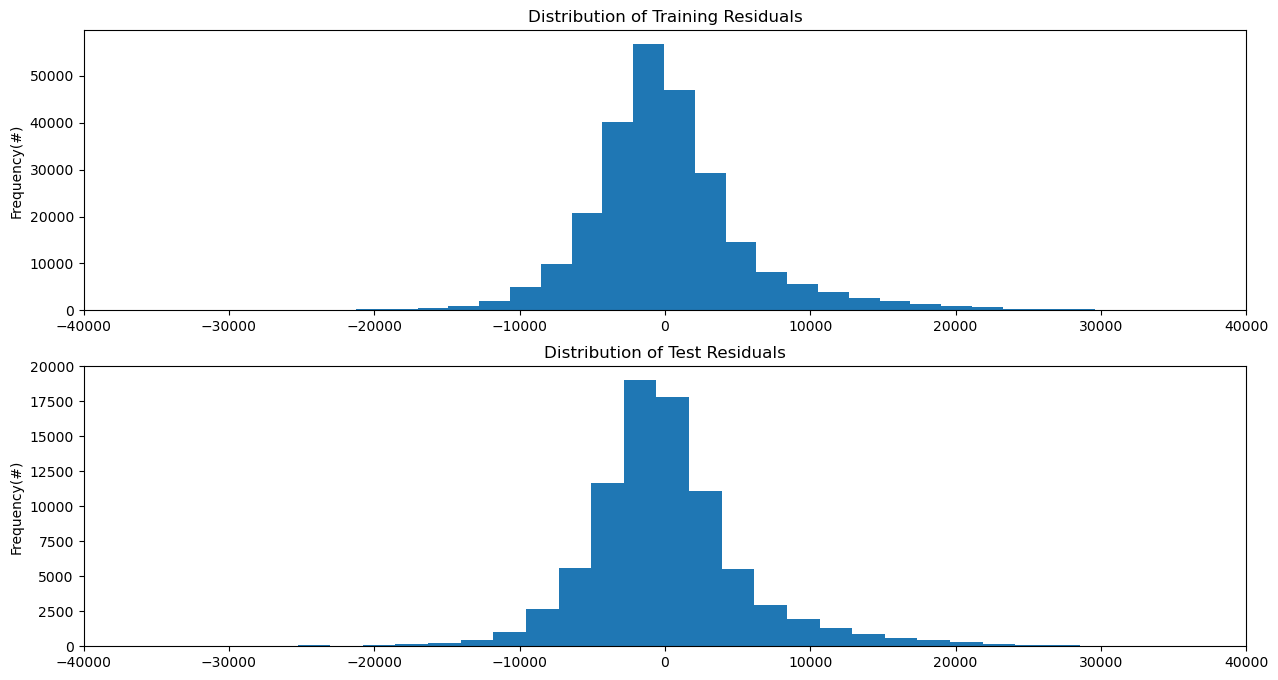

In [78]:
fig, axs = plt.subplots(2,1, figsize=(15,8))
train_preds_BestModel = pipe_BestModel.predict(X_train)
y_preds_BestModel = pipe_BestModel.predict(X_test)
axs[0].hist(y_train - train_preds_BestModel, bins=50)
axs[0].title.set_text('Distribution of Training Residuals')
axs[0].set_xlim(-40000, 40000)
axs[0].set_ylabel('Frequency(#)')

axs[1].hist(y_test - y_preds_BestModel, bins=50)
axs[1].title.set_text('Distribution of Test Residuals')
axs[1].set_xlim(-40000, 40000)
axs[1].set_ylabel('Frequency(#)')



We find that the residuals for both train and test sets are distributed normally with peak around 0.

Text(0, 0.5, 'Test Residual')

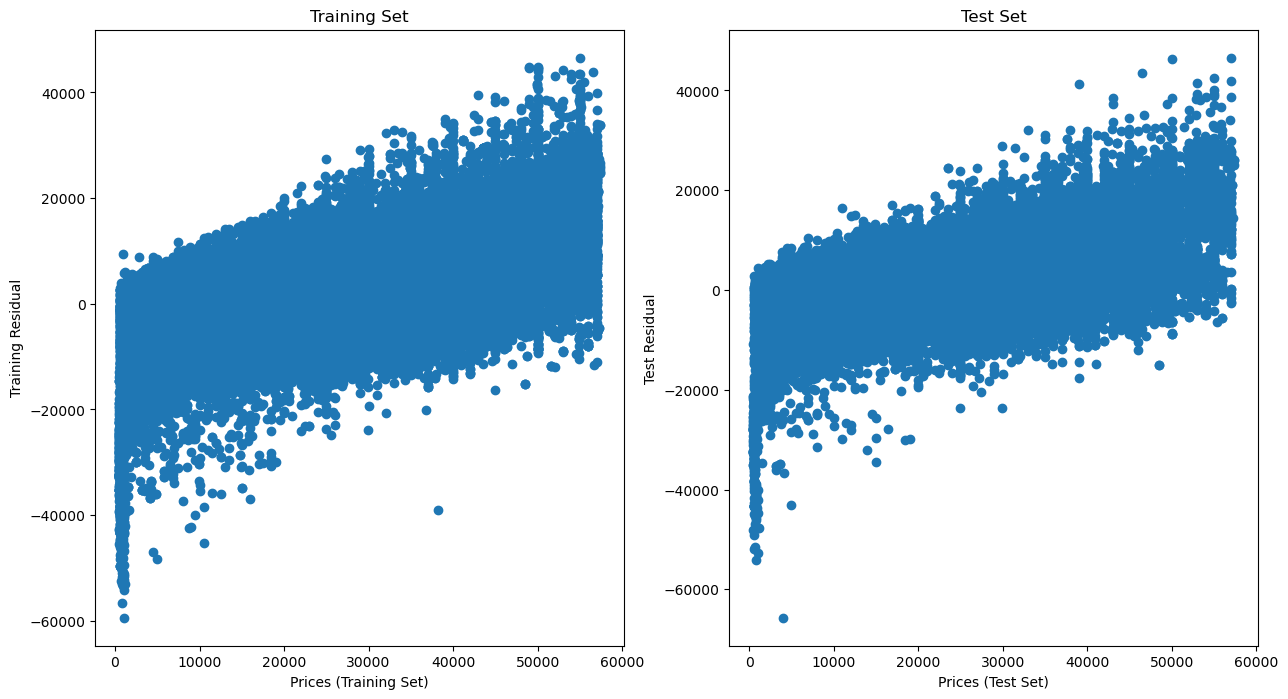

In [79]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))
axs[0].scatter(y_train, y_train - train_preds_BestModel)
axs[0].title.set_text('Training Set')
axs[0].set_xlabel('Prices (Training Set)')
axs[0].set_ylabel('Training Residual')
axs[1].scatter(y_test, y_test - y_preds_BestModel)
axs[1].title.set_text('Test Set')
axs[1].set_xlabel('Prices (Test Set)')
axs[1].set_ylabel('Test Residual')

The above plots show that the model produces more errors for prices that are on the high end or the low end , it works better for prices in the mid-range.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

**Objective**:  The goal of this analysis was *identifying the attributes that had the highest impact on used car prices.*  

**Data**: A dataset on used cars from Kaggle was explored for this purpose. After cleaning the data and retaining the attributes deemed to be relevant for modeling, the final dataset had  338553 entries with 8 attributes including manufacturer, model, year, odometer, transmission, fuel, title status and state,  and 1 target variable, price.  

**Modeling**: Different regression-based machine learning models were explored for modeling the price of used cars using 8 different attributes as mentioned above. We started with simpler models which may not be the most accurate but are easier to interpret and then proceeded to develop more complex models with higher degree polynomial features. Each of the models were explored in terms of the regression coefficients or permutation feature importance analysis in assessing the relative importance of features in terms of their influence on the predicted price.

**Results**: The best performing model was a Linear Regression model with second order polynomial features.  Based on model inspection the following five features came out on top in terms of their impact on price (highest impact listed first):

**1) model**

**2) year**

**3) odometer**

**4) transmission**

**5) fuel**

Manufacturer was not among the top five features impacting price. Interestingly, these top five features were consistently regarded as most impactful from other regression models that were explored.


**Recommendations**: **Models** of car have the biggest impact on prices. In terms of inventory, this would imply stocking up more on premium models across different manufacturers for favorable pricing rather than have different tiers of models corresponding to  a particular manufacturer. Stocking the inventory with more recent models is also important as **year** is the attribute with second most impact on price. Cars that have been driven less fetch higher prices as **odometer** is the third most impactful feature (lower the odometer, higher the price). Lastly, **transmission** (automatic or others for higher price compared to manual) and **fuel** type (diesel or electric for higher price compared to gas/hybrid) also impact price but to a lesser extent than the other three.